In [54]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=9d6c95be37d68e73e853b35ca723ab91ad92fdeb9a8ec294827ef44357fbaa89
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [1]:
import os
import cv2
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import gc; gc.collect()
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F

import torchvision
from torchvision import transforms as T
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

In [3]:
train_df_path="../input/hpa-cell-tiles-sample-balanced-dataset/cell_df.csv"
train_images_path="../input/hpa-cell-tiles-sample-balanced-dataset/cells"

In [4]:
train_df=pd.read_csv(train_df_path)
train_df = train_df.rename(columns = {'image_labels': 'Label'}, inplace = False)
train_df.head()

,image_id,r_mean,g_mean,b_mean,cell_id,Label,size1,size2
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.019785,0.007022,0.081189,1,0,510,656
1,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.021645,0.011319,0.059531,2,0,875,748
2,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.026710,0.014573,0.054268,3,0,924,760
3,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.018123,0.009205,0.065854,4,0,844,538
4,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.029577,0.014019,0.037737,5,0,620,1168


In [6]:
train=train_df['Label'].apply(lambda x:[max(list(map(int,x.split('|'))))<10])
train.tolist()
flat_list = [item for sublist in train for item in sublist]
train=train_df.iloc[flat_list]
train.head()

,image_id,r_mean,g_mean,b_mean,cell_id,Label,size1,size2
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.019785,0.007022,0.081189,1,0,510,656
1,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.021645,0.011319,0.059531,2,0,875,748
2,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.026710,0.014573,0.054268,3,0,924,760
3,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.018123,0.009205,0.065854,4,0,844,538
4,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.029577,0.014019,0.037737,5,0,620,1168


In [7]:
train['ID']=train['image_id']+ '_'+ (train['cell_id']).astype(str) 
train.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,image_id,r_mean,g_mean,b_mean,cell_id,Label,size1,size2,ID
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.019785,0.007022,0.081189,1,0,510,656,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_1
1,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.021645,0.011319,0.059531,2,0,875,748,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_2
2,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.026710,0.014573,0.054268,3,0,924,760,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_3
3,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.018123,0.009205,0.065854,4,0,844,538,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_4
4,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.029577,0.014019,0.037737,5,0,620,1168,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_5


In [8]:
index=train['Label'].apply(lambda x:[len(list(map(int,x.split('|'))))<2])
index.tolist()
flat_list = [item for sublist in index for item in sublist]
train=train.iloc[flat_list]
train.head()

,image_id,r_mean,g_mean,b_mean,cell_id,Label,size1,size2,ID
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.019785,0.007022,0.081189,1,0,510,656,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_1
1,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.021645,0.011319,0.059531,2,0,875,748,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_2
2,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.026710,0.014573,0.054268,3,0,924,760,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_3
3,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.018123,0.009205,0.065854,4,0,844,538,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_4
4,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.029577,0.014019,0.037737,5,0,620,1168,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_5


In [12]:
df=train
df.head()

,image_id,r_mean,g_mean,b_mean,cell_id,Label,size1,size2,ID
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.019785,0.007022,0.081189,1,0,510,656,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_1
1,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.021645,0.011319,0.059531,2,0,875,748,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_2
2,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.026710,0.014573,0.054268,3,0,924,760,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_3
3,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.018123,0.009205,0.065854,4,0,844,538,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_4
4,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.029577,0.014019,0.037737,5,0,620,1168,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_5


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

import time

def visualize2DSoftmax(X, y, model):
    """Function to visualize the classification boundary of a learned model on a 2-D dataset

    Arguments:
    X -- a numpy array of shape (2, N), where N is the number of data points. 
    y -- a numpy array of shape (N,), which contains values of either "0" or "1" for two different classes
    model -- a PyTorch Module object that represents a classifer to visualize. s
    """
    x_min = np.min(X[:,0])-0.5
    x_max = np.max(X[:,0])+0.5
    y_min = np.min(X[:,1])-0.5
    y_max = np.max(X[:,1])+0.5
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20), np.linspace(y_min, y_max, num=20), indexing='ij')
    xy_v = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1)))
    with torch.no_grad():
        preds = model(torch.tensor(xy_v, dtype=torch.float32))
        preds = F.softmax(preds, dim=1).numpy()

    cs = plt.contourf(xv, yv, preds[:,0].reshape(20,20), levels=np.linspace(0,1,num=20), cmap=plt.cm.RdYlBu)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=cs.ax)

def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs. 
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary. 
    desc -- a description to use for the progress bar.     
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)
        # print("labels",labels)
        

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # print("output",y_hat)
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        results[prefix + " " + name].append( score_func(y_true, y_pred))
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

def train_simple_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
        
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode
        
        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )
        
        if val_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Testing")
                    
    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(*self.shape) 
    
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
        
    def forward(self, x):
        return self.lambd(x)
    
class DebugShape(nn.Module):
    """
    Module that is useful to help debug your neural network architecture. 
    Insert this module between layers and it will print out the shape of 
    that layer. 
    """
    def forward(self, input):
        print(input.shape)
        return input
    
def weight_reset(m):
    """
    Go through a PyTorch module m and reset all the weights to an initial random state
    """
    if "reset_parameters" in dir(m):
        m.reset_parameters()
    return

def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj
        
def train_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

        
    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())
        del_opt = True
    else:
        del_opt = False

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=disable_tqdm):
      
            #Move the batch to the device we are using. 
            inputs = moveTo(inputs, device)
            labels = moveTo(labels, device)
            
            if isinstance(labels, torch.Tensor):
                batch_size = labels.shape[0]
            elif isinstance(inputs, torch.Tensor):
                batch_size = inputs.shape[0]
            else:
                batch_size = len(inputs)

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size
            
            if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            try:
                results["train " + name].append( score_func(y_true, y_pred) )
            except:
                results["train " + name].append("NaN")
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            val_running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                if isinstance(labels, torch.Tensor):
                    batch_size = labels.shape[0]
                elif isinstance(inputs, torch.Tensor):
                    batch_size = inputs.shape[0]
                else:
                    batch_size = len(inputs)
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                val_running_loss += loss.item() * batch_size

                if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
                    #moving labels & predictions back to CPU for computing / storing predictions
                    labels = labels.detach().cpu().numpy()
                    y_hat = y_hat.detach().cpu().numpy()
                    for i in range(batch_size):
                        y_true.append(labels[i])
                        y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                try:
                    results["val " + name].append( score_func(y_true, y_pred) )
                except:
                    results["val " + name].append( "NaN" )
        
        #In PyTorch, the convention is to update the learning rate after every epoch
        if not lr_schedule is None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(val_running_loss)
            else:
                lr_schedule.step()
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del optimizer

    return pd.DataFrame.from_dict(results)


In [14]:

import torch
import os
import os.path
from os import path
import cv2
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
from sklearn.metrics import accuracy_score
import time
import torchvision 
from torchvision import transforms
from PIL import Image 
from sklearn.metrics import accuracy_score
# print(torch.zeros(1).cuda())
# if torch.cuda.is_available():
#     print(True)
# else:
#     print(False)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
FLAGS={}
FLAGS['NUM_CLASSES']=10
class imagesDataset(Dataset):
    def __init__(self, path, df, img_size, Transform):
        self.path = path
        self.df = df
        self.img_ids = df['ID'].values
        self.labels = df['Label'].values
        self.img_size = img_size        
        self.transform = Transform
        
    def _get_image(self, ID):
        img = cv2.imread(self.path + '/' + ID + '.jpg', cv2.IMREAD_UNCHANGED)

        img = cv2.resize(img, (self.img_size, self.img_size))
        img = np.divide(img, 255)
        img=torch.tensor(img,dtype=torch.float32)
        img=img.permute(2, 0, 1)
        return img          
        
    def __len__(self):
        return len(self.df) 
    
    def __getitem__(self, index):
        x = self._get_image(self.img_ids[index])
        x = self.transform(x)
        y = self.labels[index]
        y = y.split('|')
        y = list(map(int, y))            
        y = np.eye(FLAGS['NUM_CLASSES'], dtype='float')[y]                                    
        y = y.sum(axis=0)
        y = torch.tensor(y,dtype=torch.long)
        return x, y


Transform = transforms.Compose(
    [transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
train_split, eval_split = train_test_split(df, test_size=0.2, random_state=42)
train_1 = imagesDataset(train_images_path, train_split, 256, Transform)   
train_loader = torch.utils.data.DataLoader(dataset=train_1,batch_size=64, shuffle=True)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))




# model 
class CNNmodel(nn.Module):

    def __init__(self):
        super(CNNmodel, self).__init__()
        self.conv_img = nn.Sequential(

            nn.Conv2d(3, 64, 3, padding=3//2), 
            nn.Tanh(),
            nn.Conv2d(64, 64, 3, padding=3//2), 
            nn.Tanh(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=3//2), 
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 2*64, 3, padding=3//2), 
            nn.Tanh(),
            nn.BatchNorm2d(128),
            nn.Flatten(), 
            nn.Linear(2097152, 10),
            
        )
       
    def forward(self, input):
        
        output=self.conv_img(input)
        output=F.softmax(output)
        output=torch.squeeze(output)

        return output


In [ ]:
model = CNNmodel()
loss = nn.BCEWithLogitsLoss()
cnn_results = train_simple_network(model, loss,train_loader, val_loader=train_loader,score_funcs={'Accuracy': accuracy}, device=device,epochs=10)

sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results, label='CNN')
print(cnn_results)
PATH = "CNNmodel.pt"
torch.save(model.state_dict(), PATH)

In [ ]:
model = get_model()
loss = nn.BCEWithLogitsLoss()
cnn_results = train_simple_network(model, loss,train_loader, val_loader=train_loader,score_funcs={'Accuracy': accuracy_score}, device=device,epochs=2)

sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results, label='CNN')
print(cnn_results)
PATH = "Resenet50.pt"
torch.save(model.state_dict(), PATH)

In [ ]:
train_split, eval_split = train_test_split(df, test_size=0.2, random_state=42)
train_1 = imagesDataset(train_images_path, train_split, 256, Transform)   
train_loader = torch.utils.data.DataLoader(dataset=train_1,batch_size=64, shuffle=True)
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b1')

for param in model.parameters():
    param.requires_grad = True
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 10)
model = model.to('cuda')

import torch
torch.cuda.empty_cache()

import torch.optim as optim 
loss_log = []
acc_log = []
optimizer = optim.Adam(model.parameters())
loss_func = nn.BCELoss()
for epoch in tqdm(range(5), desc="Epoch"):    
    model.train()    
    for ii, (data, target) in tqdm(enumerate(train_loader)):
        data, target = data.cuda(), target.cuda()
        target = target.float()                

        optimizer.zero_grad()
        output = model(data)                
    
        m = nn.Sigmoid()
        loss = loss_func(m(output), target)
#         acc = accuracy(m(output), target)
        loss.backward()

        optimizer.step()  
        
        if ii % 1000 == 0:
            loss_log.append(loss.item())
#             acc_log.append(acc.item())
       
    print('Epoch: {} - Loss: {:.6f} '.format(epoch + 1, loss.item()))
PATH = "Effenet.pt"
torch.save(model.state_dict(), PATH)

## Plotting the loss Function

In [ ]:
loss_log
plt.plot(loss_log)
plt.title('Efficient Net Loss')
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.show()

In [37]:
# print(predict_image())
test_df=df[:250]
PATH='../input/models/CNNmodel.pt'
model = CNNmodel()
model.load_state_dict(torch.load(PATH))
model.eval() 
def test_model_prediction(image_id):
#     print(image_id)
    filename="../input/hpa-cell-tiles-sample-balanced-dataset/cells/"+image_id+".jpg"
    full_filename=filename
#     full_filename=r'"../input/hpa-cell-tiles-sample-balanced-dataset/cells/0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_1.jpg"'
    img = cv2.imread(full_filename, cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, (256, 256))
    img = np.divide(img, 255)
    img=torch.tensor(img,dtype=torch.float32).unsqueeze(1)
    img=img.permute(1,3,2,0 )
    img=Transform(img) 
    x=model(img)
    x=x.detach().numpy()
#     print(np.argmax(x),label[0])
    return(np.argmax(x))

image_id = "0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_1"
# test_model_prediction(image_id=image_id,model=model,label=df[df['ID']==image_id]['Label'])
test_df['CNNmodel_prediction']=test_df['ID'].apply(lambda x: test_model_prediction(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [43]:

def get_model():  
    model = torchvision.models.resnet50()
    model.fc = nn.Linear(2048, 10, bias=True)
    return model

def get_model50():  
    model = torchvision.models.resnet50()
    model.fc = nn.Sequential(nn.Linear(2048, 10, bias=True),
                             nn.Sigmoid())
    return model

resnet50 = get_model()
# resnet34 = get_model34()
resnet50_1 = get_model50()

In [99]:
def store_prediction(model,PATH,column_name):
    model.load_state_dict(torch.load(PATH))
    model.eval() 
    def test_model_prediction(image_id):
    #     print(image_id)
        filename="../input/hpa-cell-tiles-sample-balanced-dataset/cells/"+image_id+".jpg"
        full_filename=filename
    #     full_filename=r'"../input/hpa-cell-tiles-sample-balanced-dataset/cells/0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_1.jpg"'
        img = cv2.imread(full_filename, cv2.IMREAD_UNCHANGED)
        img = cv2.resize(img, (256, 256))
        img = np.divide(img, 255)
        img=torch.tensor(img,dtype=torch.float32).unsqueeze(1)
        img=img.permute(1,3,2,0 )
        img=Transform(img) 
        model.to(device)
        x=model(img.to(device))
        x=x.cpu().data.numpy()
        return(np.argmax(x))
    test_df[column_name]=test_df['ID'].apply(lambda x: test_model_prediction(x))

def find_accuracy(column_name):
    return (len(test_df[test_df['Label']==test_df[column_name]])/test_df.shape[0])*100
    

In [73]:
test_df = df
test_df['Label']=test_df['Label'].astype(str).astype(int)
model = get_model()
PATH = '../input/models/Resenet50.pt'
column_name = 'Resnet50_prediction'
store_prediction(model=model,PATH=PATH,column_name=column_name)

0.0


In [100]:
PATH='../input/models/CNNmodel.pt'
model = CNNmodel()
column_name = 'CNNmodel_prediction'
store_prediction(model=model,PATH=PATH,column_name=column_name)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [77]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b1')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 10)
PATH = '../input/efficientnet/Effenet.pt'
column_name = 'Efficientnet_prediction'
store_prediction(model=model,PATH=PATH,column_name=column_name)

0.0


In [96]:
print(find_accuracy(column_name='Efficientnet_prediction'))

62.65557389481198


In [95]:
print(find_accuracy(column_name='Resnet50_prediction'))

14.835838872284427


In [102]:
print(find_accuracy(column_name='CNNmodel_prediction'))

29.661640719097115


In [103]:
test_df.to_csv('predictions.csv')

In [146]:
# print(predict_image())
full_filename=r"../input/hpa-cell-tiles-sample-balanced-dataset/cells/e399641a-bbbd-11e8-b2ba-ac1f6b6435d0_1.jpg"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
img = cv2.imread(full_filename, cv2.IMREAD_UNCHANGED)
img = cv2.resize(img, (256, 256))
img = np.divide(img, 255)
img=torch.tensor(img,dtype=torch.float32).unsqueeze(1)
img=img.permute(1,3,2,0 )
img=Transform(img)
img.to(device)
# model=CNNmodel()
# model.load_state_dict(torch.load(PATH))
model.eval()  
x=model(img.to(device))
# x=x.detach().numpy()
print(x)


tensor([[ -5.0191,  -8.9252,  -3.8230,  -2.0727,   1.5563,  -2.9799, -10.0418,
          -8.6046,  -7.5217,  -8.2253]], device='cuda:0',
       grad_fn=<AddmmBackward>)


### Sample Images of the dataset

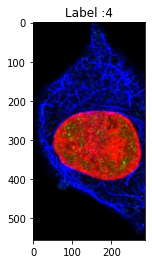

In [112]:
full_filename=r"../input/hpa-cell-tiles-sample-balanced-dataset/cells/e399641a-bbbd-11e8-b2ba-ac1f6b6435d0_4.jpg"

sample_image=cv2.imread(full_filename, cv2.IMREAD_UNCHANGED)
plt.figure()
plt.imshow(sample_image) 
plt.title('Label :'+str(test_df[test_df['ID']=='e399641a-bbbd-11e8-b2ba-ac1f6b6435d0_4']['Label'].iloc[0]))
plt.show()

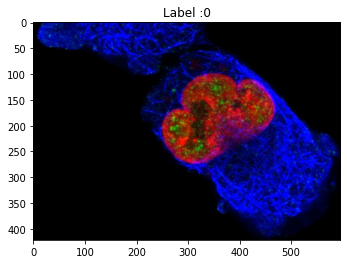

In [145]:
import cv2
full_filename=r"../input/hpa-cell-tiles-sample-balanced-dataset/cells/e399641a-bbbd-11e8-b2ba-ac1f6b6435d0_1.jpg"

sample_image=cv2.imread(full_filename, cv2.IMREAD_UNCHANGED)
plt.figure()
plt.imshow(sample_image) 
plt.title('Label :'+str(test_df[test_df['ID']=='0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_8']['Label'].iloc[0]))
plt.show()

In [ ]:
model_resnet50_cross = get_model50()
loss = nn.BCEWithLogitsLoss()
model_resnet50_cross_results = train_simple_network(model_resnet50_cross, loss,train_loader, val_loader=train_loader,score_funcs={'Accuracy': accuracy}, device=device,epochs=5)

sns.lineplot(x='epoch', y='val Accuracy', data=model_resnet50_cross_results, label='CNN')
print(model_resnet50_cross_results)
PATH = "Resenet50_1.pt"
torch.save(model_resnet50_cross.state_dict(), PATH)

In [ ]:
model_resnet50_cross_results = train_simple_network(model_resnet50_cross, loss,train_loader, val_loader=train_loader,score_funcs={'Accuracy': accuracy}, device=device,epochs=5)

sns.lineplot(x='epoch', y='val Accuracy', data=model_resnet50_cross_results, label='CNN')
print(model_resnet50_cross_results)
PATH = "Resenet50_1.pt"
torch.save(model_resnet50_cross.state_dict(), PATH)

In [ ]:
model_resnet50_cross_entropy = get_model()
loss = nn.CrossEntropyLoss()
model_resnet50_cross_entropy_results = train_simple_network(model_resnet50_cross_entropy, loss,train_loader, val_loader=train_loader,score_funcs={'Accuracy': accuracy_score}, device=device,epochs=1)

sns.lineplot(x='epoch', y='val Accuracy', data=model_resnet50_cross_entropy, label='CNN')
print(model_resnet50_cross_entropy)
PATH = "Resenet50_2.pt"
torch.save(model_resnet50_cross_entropy.state_dict(), PATH)

In [ ]:
# print(predict_image())
full_filename=r"../input/hpa-cell-tiles-sample-balanced-dataset/cells/7f7ac4ba-bbb3-11e8-b2ba-ac1f6b6435d0_1.jpg"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
img = cv2.imread(full_filename, cv2.IMREAD_UNCHANGED)
img = cv2.resize(img, (256, 256))
img = np.divide(img, 255)
img=torch.tensor(img,dtype=torch.float32).unsqueeze(1)
img=img.permute(1,3,2,0 )
img=Transform(img)
img.to(device)
# model=get_model()
# model.to(device)
# model.load_state_dict(torch.load('../input/models/Resenet50.pt'))
model.eval()  
x=model(img.to(device))
# x=x.detach().numpy()
print(x)


In [113]:
train_df_path="../input/hpa-single-cell-image-classification/train.csv"
train_images_path="../input/hpa-single-cell-image-classification/train"

In [114]:
!pip install 'git+https://github.com/haoxusci/pytorch_zoo@master#egg=pytorch_zoo'

  Cloning https://github.com/haoxusci/pytorch_zoo (to revision master) to /tmp/pip-install-5a6luov6/pytorch-zoo_297522383b3541029a02fe40556f05f7
  Running command git clone -q https://github.com/haoxusci/pytorch_zoo /tmp/pip-install-5a6luov6/pytorch-zoo_297522383b3541029a02fe40556f05f7
  Created wheel for pytorch-zoo: filename=pytorch_zoo-0.0.0-py3-none-any.whl size=30139 sha256=2a2c368b540bbff5471f213ab00567ade316c4fe65fb9d71964045f10638d0ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-c1gs5gj_/wheels/51/c6/4b/db98c6ef97234d24a77e33d23b429e2f7e19bf2dfed8422a72
Successfully built pytorch-zoo


In [115]:
!pip install https://github.com/CellProfiling/HPA-Cell-Segmentation/archive/master.zip

     - 17 kB 607 kB/ss/s
     / 131 kB 933 kB/s/s
  Created wheel for hpacellseg: filename=hpacellseg-0.1.8-py3-none-any.whl size=14938 sha256=95ce39df02fc0a8ab8ef32d689f37de3593983c8b6799f7c66e9cded8bf0f141
  Stored in directory: /tmp/pip-ephem-wheel-cache-_og6j0_o/wheels/cd/d8/de/04ad08802d62537f8dffc89b6a7ce0a53c3d29ea6eae522ab1
Successfully built hpacellseg


In [116]:
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei

In [117]:
ROOT_PATH = '/kaggle/input/hpa-single-cell-image-classification/'

CHANNELS = np.array(['red', 'green', 'blue', 'yellow'])

CHANNEL_RED = 0    # microtubule channels
CHANNEL_GREEN = 1  # protein of interest
CHANNEL_BLUE = 2   # nuclei channels
CHANNEL_YELLOW = 3 # endoplasmic reticulum 

CHANNEL_SIZE = len(CHANNELS)
SAMPLE_SIZE = 5



In [118]:
#
# Get array of all images for given sample id
#
def get_images(id):
    images = list()
    for channel in CHANNELS:
        path = ROOT_PATH + 'train/{}_{}.png'.format(id, channel)
        image = Image.open(path) 
        images.append(image)
    return images

#
# Get single image that blends all RGBY into RGB
#
def get_blended_image(id): 
    # get rgby images for sample
    images = get_images(id)

    # blend rgby images into single array
    blended_array = np.stack((
            images[0],
            images[1],
            images[2]
        ), 2)

    # Create PIL Image
    blended_image = Image.fromarray( np.uint8(blended_array) )
    return blended_image

In [119]:
df_train = pd.read_csv(ROOT_PATH + 'train.csv')
print("Training data length: {}".format(len(df_train)))
df_train.head()

Training data length: 21806


,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


In [120]:
NUC_MODEL = "./nuclei-model.pth"
CELL_MODEL = "./cell-model.pth"
segmentator = cellsegmentator.CellSegmentator(
    NUC_MODEL,
    CELL_MODEL,
    scale_factor=0.25,
    device="cuda",
    padding=False,
    multi_channel_model=True,
)

Could not find ./nuclei-model.pth. Downloading it now


please compile abn


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'pytorch_zoo.unet.DPNUnet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set

In [169]:
sample_id='60bfc742-bb99-11e8-b2b9-ac1f6b6435d0'

images = get_images(sample_id)

nuc_segmentations = segmentator.pred_nuclei([np.asarray( images[CHANNEL_BLUE] )])
print(np.shape(nuc_segmentations))

# For full cells
cell_segmentations = cell_segmentations = segmentator.pred_cells([
        [np.asarray( images[CHANNEL_RED] )],
        [np.asarray( images[CHANNEL_GREEN] )],
        [np.asarray( images[CHANNEL_BLUE] )]
    ])
print(np.shape(cell_segmentations))

nuclei_mask = label_nuclei(nuc_segmentations[0])
print(np.shape(nuclei_mask))

cell_nuclei_mask, cell_mask = label_cell(nuc_segmentations[0], cell_segmentations[0])
print(np.shape(nuclei_mask))
print(np.shape(cell_mask))

(1, 2048, 2048, 3)
(1, 2048, 2048, 3)
(2048, 2048)
(2048, 2048)
(2048, 2048)


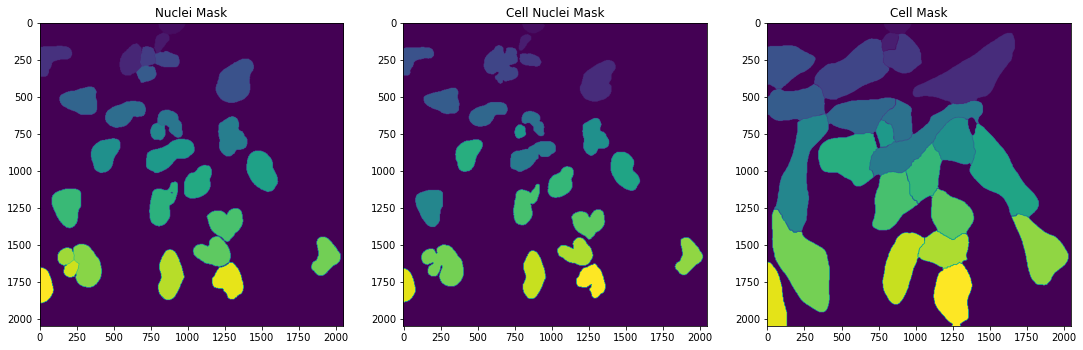

In [170]:
fig = plt.figure(figsize=(25,25))

# Nuclei mask
nuclei_image = Image.fromarray( np.uint8(nuclei_mask) )

ax = fig.add_subplot(1, 4, 1)
ax.set_title("Nuclei Mask")
plt.imshow(np.asarray(nuclei_image))

# Cell nuclei mask
cell_nuclei_image = Image.fromarray( np.uint8(cell_nuclei_mask) )

ax = fig.add_subplot(1, 4, 2)
ax.set_title("Cell Nuclei Mask")
plt.imshow(np.asarray(cell_nuclei_image))

# Cell mask
cell_image = Image.fromarray( np.uint8(cell_mask) )

ax = fig.add_subplot(1, 4, 3)
ax.set_title("Cell Mask")
plt.imshow(np.asarray(cell_image))

In [171]:
def smallestbox(a,b):
    r = a.any(1)
    if r.any():
        m,n = a.shape
        c = a.any(0)
        out = b[r.argmax():m-r[::-1].argmax(), c.argmax():n-c[::-1].argmax()]
    else:
        out = np.empty((0,0),dtype=bool)
    return out

In [168]:
df_train[df_train['Label']=='5']

,ID,Label
14,60bfc742-bb99-11e8-b2b9-ac1f6b6435d0,5
40,6f303dfc-bb99-11e8-b2b9-ac1f6b6435d0,5
44,6f38b45a-bb99-11e8-b2b9-ac1f6b6435d0,5
93,89d1164a-bb99-11e8-b2b9-ac1f6b6435d0,5
130,a2c63252-bb99-11e8-b2b9-ac1f6b6435d0,5
...,...,...
21618,788b974e-bbca-11e8-b2bc-ac1f6b6435d0,5
21620,79a48dd4-bbca-11e8-b2bc-ac1f6b6435d0,5
21702,a78c9cd2-bbca-11e8-b2bc-ac1f6b6435d0,5
21753,c477f314-bbca-11e8-b2bc-ac1f6b6435d0,5


In [196]:
# full_filename=r"../input/hpa-cell-tiles-sample-balanced-dataset/cells/0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_1.jpg"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b1')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 10)
PATH = '../input/efficientnet/Effenet.pt'
model.to(device)
model.load_state_dict(torch.load(PATH))
model.eval()  
# x=x.detach().numpy()
def predict_cell_type(img,sample_id,count):
#     print(sample_id)
    file_name = r"../input/hpa-cell-tiles-sample-balanced-dataset/cells/"+str(sample_id)+"_"+str(count+1)+".jpg"
#     print(file_name)
    img = cv2.imread(file_name, cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, (256, 256))
    img = np.divide(img, 255)
    img=torch.tensor(img,dtype=torch.float32).unsqueeze(1)
    img=img.permute(1,3,2,0 )
    img=Transform(img)
    x=model(img.to(device))
    # x=x.detach().numpy()
#     x=x.cpu().data.numpy()
#     return(np.argmax(x))
    _,label=torch.max(x, dim=1)
    return(label.cpu().data.numpy())

error: OpenCV(4.5.1) /tmp/pip-req-build-tk9iuyva/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


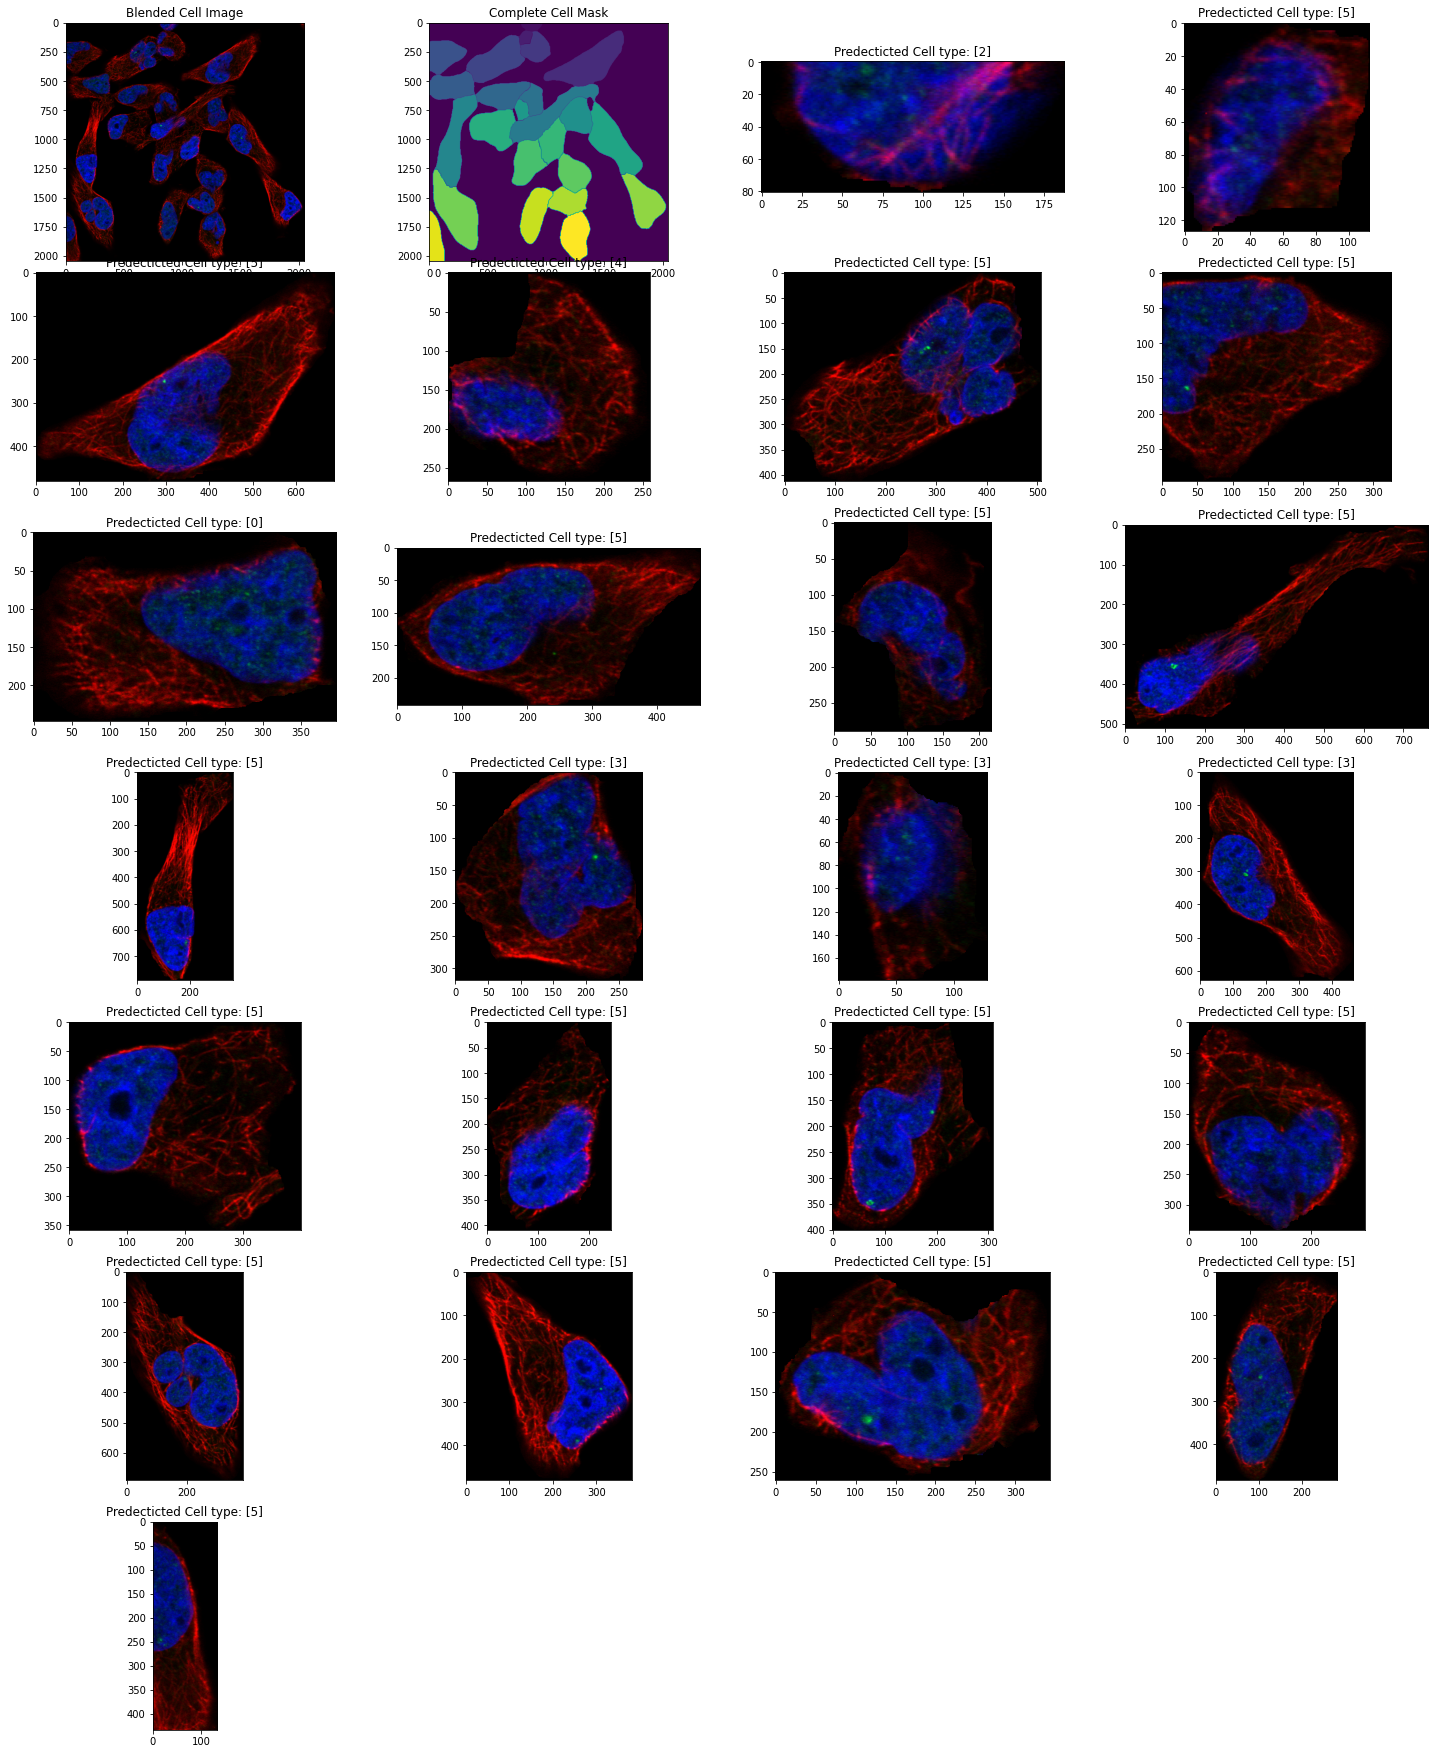

In [201]:
from collections import Counter
blended_image = get_blended_image(sample_id)
blended_array = np.asarray(blended_image)

# Get unique vector of segment numbers
numbers = np.unique(cell_mask)
numbers = np.delete(numbers, [0])

# build figure
fig = plt.figure(figsize=(25,6*len(numbers)/4))
index = 1

# plot original cell mask from above
ax = fig.add_subplot((len(numbers)//4)+1, 4, index)
ax.set_title("Blended Cell Image")
plt.imshow(np.asarray(blended_image))
index = index + 1

# plot original cell mask from above
ax = fig.add_subplot((len(numbers)//4)+1, 4, index)
ax.set_title("Complete Cell Mask")
plt.imshow(np.asarray(cell_image))
index = index + 1
cell_types=[]
for i,number in enumerate(numbers):
    # set all other 'numbers' to 255 in cell mask
    isolated_mask = np.where(cell_mask == number, True, False)
    isolated_mask1 = isolated_mask
    # match shape for RGB
    isolated_mask = np.stack((isolated_mask, isolated_mask, isolated_mask), axis=2)
    
    # crop across all channels
    isolated_image = np.where(isolated_mask == True, blended_array, 0)
    isolated_image1 = smallestbox(isolated_mask1,isolated_image)
    # plot isolated image
    cell_type = predict_cell_type(isolated_image1,sample_id,i)
    cell_types.append(int(cell_type))
    ax = fig.add_subplot((len(numbers)//4)+2, 4, index)
    ax.set_title("Predecticted Cell type: {}".format(cell_type))

    plt.imshow(isolated_image1)
    index = index + 1
print(Counter(cell_types))

## Count of Cell_types

In [204]:
print(Counter(cell_types))

Counter({5: 17, 3: 3, 2: 1, 4: 1, 0: 1})
